# Modelling polydeformation

### Import the Forward Modelling Engine modules - FME

In [1]:
#import the Forward Modelling Engine modules - FME
from FME.interpolators.piecewiselinear_interpolator import PiecewiseLinearInterpolator as PLI
from FME.interpolators.discrete_fold_interpolator import DiscreteFoldInterpolator as DFI
from FME.modelling.features.geological_feature import GeologicalFeatureInterpolator
from FME.modelling.structural_frame import StructuralFrameBuilder
from FME.modelling.fold.foldframe import FoldFrame
from FME.modelling.fold.fold import FoldEvent
from FME.modelling.fold.svariogram import SVariogram
from FME.supports.tet_mesh import TetMesh
from FME.visualisation.model_visualisation import LavaVuModelViewer
from FME.visualisation.rotation_angle_plotter import RotationAnglePlotter
# import other libraries
import pandas as pd
import numpy as np
import glob
import os
from scipy.interpolate import Rbf
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

In [2]:
class fold_rotation_angle_feature:
    def __init__(self,fold_frame,rotation):
        self.fold_frame = fold_frame
        self.rotation = rotation
    def evaluate_value(self,location):
        s1 = self.fold_frame.features[0].evaluate_value(location)
        r = self.rotation(s1)
        return r

### Use a Fourier series to represent the fold geometry
This is just a function F(x,params) that can be passed to scipy curve fit with an estimate on the parameter values. The parameters can then be fit to the observations.

In [3]:
def fourier_series(x,c0,c1,c2,w):
    v = np.array(x.astype(float))
    v.fill(c0)
    v = c0 + c1*np.cos(2*np.pi/w*x) + c2*np.sin(2*np.pi/w*x)
    return np.rad2deg(np.arctan(v))

### Load data from csv files
Use glob to find all csvs in directory and then import into a dictionary of pandas data frames

In [4]:
data ={}
for f in glob.glob('data/noddy_synth/*.csv'):
    data[os.path.basename(f)] = np.loadtxt(f,delimiter=" ")
    
origin = (0,0,0)
maximum = (10000,10000,5000)
print(data.keys())

dict_keys(['s2_val.csv', 's0_dir.csv', 's0_val.csv', 's2_dir.csv', 's1_val.csv', 's1_dir.csv'])


#### Building the Mesh

Build a mesh that covers at least the area of interest. In this case use the origin and maximum extent. Define the number of tetras - start with a moderate number 50k and work upwards when the model is working.

In [5]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = origin[0]
boundary_points[0,1] = origin[1]
boundary_points[0,2] = origin[2]
boundary_points[1,0] = maximum[0]
boundary_points[1,1] = maximum[1]
boundary_points[1,2] = maximum[2]
mesh = TetMesh()
mesh.setup_mesh(boundary_points, n_tetra=90000,)

### Building the Fold Frame F2

Associate the different coordinates of the fold frame with the data that defines their geometry.

* coordinate 0 is associated with the axial foliation
* coordinate 1 is associated with the fold axis direction which is either an observation of the fold axis or can be defined as the strike rotated by 90

In [6]:
#print(data['s2_dir.csv'])
fold_frame2_interpolator = PLI(mesh)
fold_frame2_builder = StructuralFrameBuilder(
    interpolator=fold_frame2_interpolator,
    mesh=mesh,
    name='F2_fold_frame')
# Interfacing with dataframes should be done using a convenience wrapper function
for r in data['s2_dir.csv']:
    if r[3] < -10:
        continue
    fold_frame2_builder.add_planar_constraint(r[0:3],-r[3:],itype='gx')
    fold_frame2_builder.add_planar_constraint(r[0:3],[r[4],r[3],r[5]],itype='gy')

r = data['s2_val.csv']
fold_frame2_builder.add_point(r[0:3],r[3],itype='gx')
fold_frame2_builder.add_point(r[0:3],r[3],itype='gy')

Run interpolation with default parameters using lu solver

In [7]:
f2_frame = fold_frame2_builder.build(
    frame=FoldFrame,
    solver='lu',
)

Building gx
Building gy
Creating analytical gz


Now we can visualize the fold frame isosurfaces with Lavavu

In [8]:
# viewer = LavaVuModelViewer(background="white")
# viewer.plot_model_box(boundary_points,
#                       (100,100,50),
#                       's2',
#                       paint_with=f2_frame.features[0],
#                      cmap='jet')
# viewer.plot_isosurface(f2_frame.features[0],  colour='green')
# viewer.plot_isosurface(f2_frame.features[1],  colour='blue')
# viewer.plot_data(f2_frame.features[0])
# viewer.interactive()

#### Create a fold linked to the fold frame<br>
We need to create a fold event that links our fold frame to the fold event so that it can given to the fold interpolator.

In [9]:
fold = FoldEvent(f2_frame,None,None)

### Create a DiscreteFoldInterpolator object
The DiscreteFoldInterpolator is a PiecewiseLinearInterpolator that adds additional constraints to the interpolation process using the geometry of the fold. It can be initialised using a fold and mesh. 

In [10]:
f1_fold_interpolator = DFI(mesh,fold)

In [11]:
#print(data['s2_dir.csv'])
fold_frame1_interpolator = PLI(mesh)
fold_frame1_builder = StructuralFrameBuilder(
    interpolator=fold_frame1_interpolator,
    mesh=mesh,
    name='F1_fold_frame')
# update the coordinate 0 interpolator to be a fold interpolator
fold_frame1_builder.interpolators[0] = f1_fold_interpolator
fold_frame1_builder.interpolators[0].set_property_name(fold_frame1_builder.name+'_gx')
for r in data['s1_dir.csv']:
    if r[3] < -10:
        continue
    fold_frame1_builder.add_planar_constraint(r[0:3],r[3:],itype='gx')

# because type 3 interference the gy can be the same for different folds.
for r in data['s2_dir.csv']:
    if r[3] < -10:
        continue
#     fold_frame2_builder.add_planar_constraint(r[0:3],-r[3:],itype='gx')
    fold_frame1_builder.add_planar_constraint(r[0:3],[r[4],r[3],r[5]],itype='gy')
    
for r in data['s1_val.csv']:
    fold_frame1_builder.add_point(r[0:3],r[3],itype='gx')
r = data['s2_val.csv']
# fold_frame1_builder.add_point(r[0:3],r[3],itype='gx')
fold_frame1_builder.add_point(r[0:3],r[3],itype='gy')

In [12]:
xyz = data['s1_dir.csv'][:,:3]#fold_frame1_builder.interpolators[0].get_gradient_control()[:,:3]
s1g = data['s1_dir.csv'][:,3:]##fold_frame1_builder.interpolators[0].get_gradient_control()[:,3:]
l2 = f2_frame.calculate_intersection_lineation(np.hstack([xyz,s1g]))
far = f2_frame.calculate_fold_axis_rotation(np.hstack([xyz,l2]))
s2 = f2_frame.features[0].evaluate_value(xyz)
s2gy = f2_frame.features[1].evaluate_value(xyz)
axis_svariogram = SVariogram(s2gy,far)
guess = np.array(axis_svariogram.find_wavelengths())
guess[0] = guess[1]/2.

In [13]:
far_tan = np.tan(np.deg2rad(far))

xi = np.linspace(f2_frame.features[1].min(),
                 f2_frame.features[1].max(), 1000)

In [14]:
def fold_axis_rotation(x):
    v = np.zeros(x.shape)
    v[:] = np.mean(far)#0
    #print(v)
#     print(v)
    return v
    #return np.rad2deg(np.arctan(rbf_fold_axis(x,np.zeros(x.shape),np.zeros(x.shape))))
fold.fold_axis_rotation = fold_axis_rotation

In [15]:
fold.get_fold_axis_orientation(np.array([[10,10,10]]))

array([[-0.00489875,  0.71358393, -0.70055262]])

In [16]:
axis = fold.get_fold_axis_orientation(xyz)
flr = f2_frame.calculate_fold_limb_rotation(np.hstack([xyz,s1g]),axis=axis)
limb_svariogram = SVariogram(s2,flr)
guess = limb_svariogram.find_wavelengths()
guess = np.array(limb_svariogram.find_wavelengths())
guess[0] /=2

flr_tan = np.tan(np.deg2rad(flr))
limb_svariogram = SVariogram(s2,flr)
guess = np.array(limb_svariogram.find_wavelengths())
guess = np.zeros(4)
guess[3] = 5000
popt, pcov = curve_fit(fourier_series,s2,flr_tan,guess)
xi = np.linspace(f2_frame.features[0].min(),f2_frame.features[0].max(),1000)
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(fourier_series(x,popt[0],popt[1],popt[2],popt[3])))
# flr = fold_rotation_angle_feature(f2_frame,fold_limb_rotation)
fold.fold_limb_rotation = fold_limb_rotation

Text(0.5, 1.0, 'Fold axis rotation angle S-Variogram')

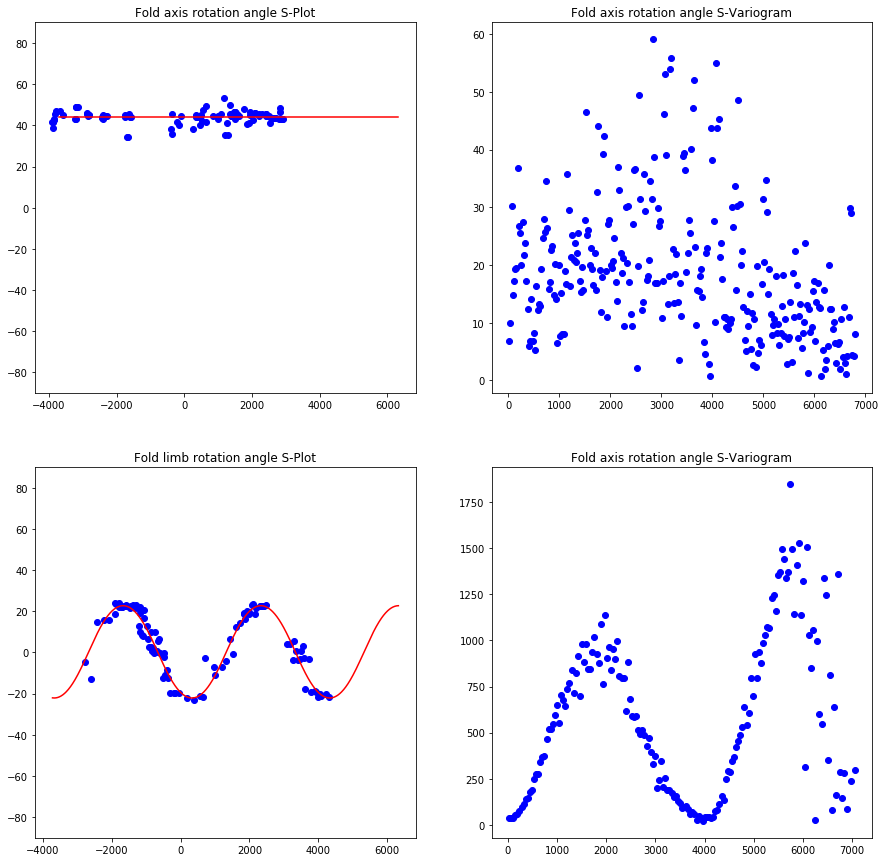

In [17]:
rotation_plots = RotationAnglePlotter()
rotation_plots.add_fold_axis_data(far,s2gy)
rotation_plots.add_axis_svariogram(axis_svariogram)
rotation_plots.add_fold_axis_curve(fold.fold_axis_rotation(xi),xi)
rotation_plots.add_fold_limb_data(flr,s2)
rotation_plots.add_limb_svariogram(limb_svariogram)
rotation_plots.add_fold_limb_curve(fold.fold_limb_rotation(xi), xi)
rotation_plots.ax[0][0].set_title("Fold axis rotation angle S-Plot")
rotation_plots.ax[0][1].set_title("Fold axis rotation angle S-Variogram")
rotation_plots.ax[1][0].set_title("Fold limb rotation angle S-Plot")
rotation_plots.ax[1][1].set_title("Fold axis rotation angle S-Variogram")

In [ ]:
fold_weights = {}
fold_weights['fold_orientation'] = 100. # reference values?
fold_weights['fold_axis'] = 100. # reference values?
fold_weights['fold_normalisation'] = 1. # reference values?
fold_weights['fold_regularisation'] = 5.10# reference values?
# fold_frame1_builder.interpolators[0].n_g= 0
f1_frame = fold_frame1_builder.build(solver='lu',
                                         frame=FoldFrame,
                                    fold_weights=fold_weights,
                                    fold=fold)

In [ ]:
fold.get_fold_axis_orientation(np.array([[15,15,10]]))
locations = mesh.barycentre[::100,:]
r2r, axis, dgz = fold.get_deformed_orientation(locations)

In [ ]:
# viewer = LavaVuModelViewer(background="white")
# viewer.plot_vector_data(locations,r2r,'r2r',colour='red')
# viewer.plot_vector_data(locations,dgz,'dgz',colour='green')
# viewer.plot_vector_data(locations,axis,'axis',colour='purple')
# viewer.plot_vector_data(locations,np.cross(r2r,axis,axisa=1,axisb=1),'x')

# viewer.interactive()

In [ ]:
# viewer = LavaVuModelViewer(background="white")
# # viewer.plot_model_box(boundary_points,
# #                       (100,100,50),
# #                       's0',
# #                       paint_with=f1_frame.features[0])
# viewer.plot_isosurface(f1_frame.features[0],
#                        paint_with=f1_frame.features[0],
#                        nslices=1,
#                        slices=[0,1,5],
# #                        colour='green',
#                       )
# viewer.plot_isosurface(f1_frame.features[1],
# #                        nslices=10,
#                        colour='green')
# # viewer.plot_isosurface(f2_frame.features[0])
# # viewer.plot_isosurface(f2_frame.features[1],
# #                        colour='blue')
# # viewer.plot_vector_data(locations,s1g,'s1g')
# # viewer.plot_vector_data(locations,FX,'axis')
# # viewer.plot_vector_data(locations,R2R,'r2r')
# # viewer.plot_vector_data(locations,np.cross(R2R,FX,axisa=1,axisb=1),'folded')
# viewer.plot_vector_data(xyz,s1g,'s0',size=2)
# viewer.plot_vector_data(xyz,l2,'l2',size=2)
# viewer.plot_vector_data(xyz,fold.get_fold_axis_orientation(xyz),'axis',size=2)
# viewer.plot_vector_data(xyz,f2_frame.features[1].evaluate_gradient(xyz),'gy',size=2)
# viewer.plot_vector_data(locations,r2r,'r2r')
# viewer.plot_data(f1_frame.features[0])
# viewer.interactive()

In [ ]:
# axis = fold.get_fold_axis_orientation(xyz)
# axis/=np.linalg.norm(axis,axis=1)[:,None]
# l2/=np.linalg.norm(l2,axis=1)[:,None]
# gy = f2_frame.features[1].evaluate_gradient(xyz)

# d = l2[:,0]*axis[:,0]+l2[:,1]*axis[:,1]+l2[:,2]*axis[:,2]
# de = np.einsum('ij,ij->i',gy,l2)
# print(np.rad2deg(np.arccos(de)))
# viewer = LavaVuModelViewer(background="white")

# viewer.plot_vector_data(xyz[0:2,:],axis[0:2,:],'s0',size=2)
# viewer.plot_vector_data(xyz[0:2,:],l2[0:2,:],'l2')
# viewer.plot_vector_data(xyz[0:2,:],gy[0:2,:],'gy')

# viewer.interactive()
# print(np.rad2deg(np.arccos(d)))

In [ ]:
axis = fold.get_fold_axis_orientation(xyz)
axis/=np.linalg.norm(axis,axis=1)[:,None]
l2/=np.linalg.norm(l2,axis=1)[:,None]
gy = f2_frame.features[1].evaluate_gradient(xyz)


print('gy l2',np.rad2deg(np.arccos(np.einsum('ij,ij->i',gy,l2))))
print('gy axis',np.rad2deg(np.arccos(np.einsum('ij,ij->i',gy,axis))))
print('axis l2',np.rad2deg(np.arccos(np.einsum('ij,ij->i',axis,l2))))



In [ ]:
rot = fold.rot_mat(np.array([[0,0,1],[0,0,1],[0,0,1]]),np.array([65.,45,60]))
# rotated = rot @ np.array([[1,0,0]])
fold_axis = np.einsum('ijk,ki->kj',rot, np.array([[1,0,0],[1,0,0],[1,0,0]]))
dot = fold_axis[0,:]*1.
print(dot)
print(np.rad2deg(np.arccos(dot)))

In [ ]:
dgx = f2_frame.features[0].evaluate_gradient(xyz)
dgy = f2_frame.features[1].evaluate_gradient(xyz)
# get gy
gy = f2_frame.features[0].evaluate_value(xyz)
dgx/=np.linalg.norm(dgx,axis=1)[:,None]
dgy/=np.linalg.norm(dgy,axis=1)[:,None]
R1 = fold.rot_mat(dgx,fold.fold_axis_rotation(gy))
print(fold.fold_axis_rotation(gy))
fold_axis = np.einsum('ijk,ki->kj',R1,dgy)
# print(
fold_axis/=np.linalg.norm(fold_axis,axis=1)[:,None]
print(fold_axis.shape,dgy.shape)
print(np.rad2deg(np.arccos(np.einsum('ij,ij->i',fold_axis,dgy))))
# np.rad2deg(np.arccos(np.einsum('ij,ij->i',gy,l2))))

In [ ]:
print(f1_frame.features[0].support.interpolator.get_control_points())

In [ ]:
f1 = FoldEvent(f1_frame,None,None)
stratigraphy_interpolator = DFI(mesh, f1)
# #
# # # ### Build the stratigraphy geological feature
# # # We can build the stratigraphy geological feature using the fold interpolator object and
# # # then linking the observations from the shapefile to the interpolator. .
# #
stratigraphy_builder = GeologicalFeatureInterpolator(stratigraphy_interpolator, 
                                                     name="folded_stratigraphy")
for r in data['s0_dir.csv']:
    stratigraphy_builder.add_planar_constraint(r[:3],-r[3:])

strati = stratigraphy_builder.build(cgw=0,solver=None)
# viewer.plot_vector_data(strati.support.interpolator.get_gradient_control()[:,:3],
#                         strati.support.interpolator.get_gradient_control()[:,3:],
#                         "strati_grad2",
#                         colour='green')
strati_g = strati.support.interpolator.get_gradient_control()





In [ ]:
xyz = strati_g[:,:3]#fold_frame1_builder.interpolators[0].get_gradient_control()[:,:3]
s0g = strati_g[:,3:]##fold_frame1_builder.interpolators[0].get_gradient_control()[:,3:]
l1 = f1_frame.calculate_intersection_lineation(np.hstack([xyz,s0g]))
far = f1_frame.calculate_fold_axis_rotation(np.hstack([xyz,l1]))
s1 = f1_frame.features[0].evaluate_value(xyz)
s1gy = f1_frame.features[1].evaluate_value(xyz)
axis_svariogram = SVariogram(s1gy,far)
guess = np.array(axis_svariogram.find_wavelengths())
guess[0] = guess[1]/2.

far_tan = np.tan(np.deg2rad(far))
xi = np.linspace(f1_frame.features[1].min(),
                 f1_frame.features[1].max(), 1000)
def fold_axis_rotation(x):
    v = np.zeros(x.shape)
    v[:] = np.mean(far)#0
    return v
    #return np.rad2deg(np.arctan(rbf_fold_axis(x,np.zeros(x.shape),np.zeros(x.shape))))
f1.fold_axis_rotation = fold_axis_rotation

axis = f1.get_fold_axis_orientation(xyz)
flr = f1_frame.calculate_fold_limb_rotation(np.hstack([xyz,s0g]),axis=axis)
limb_svariogram = SVariogram(s1,flr)
guess = limb_svariogram.find_wavelengths()
guess = np.array(limb_svariogram.find_wavelengths())
guess[0] /=2

flr_tan = np.tan(np.deg2rad(flr))
limb_svariogram = SVariogram(s1,flr)
guess = np.array(limb_svariogram.find_wavelengths())
guess = np.zeros(4)
guess[3] = 5000
popt, pcov = curve_fit(fourier_series,s1,flr_tan,guess)
xi = np.linspace(f1_frame.features[0].min(),f1_frame.features[0].max(),1000)
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(fourier_series(x,popt[0],popt[1],popt[2],popt[3])))

# flr = fold_rotation_angle_feature(f2_frame,fold_limb_rotation)
f1.fold_limb_rotation = fold_limb_rotation
f1_limb_feature = fold_rotation_angle_feature(f1_frame,fold_limb_rotation)
rotation_plots = RotationAnglePlotter()
rotation_plots.add_fold_axis_data(far,s1gy)
rotation_plots.add_axis_svariogram(axis_svariogram)
rotation_plots.add_fold_axis_curve(fold.fold_axis_rotation(xi),xi)
rotation_plots.add_fold_limb_data(flr,s1)
rotation_plots.add_limb_svariogram(limb_svariogram)
rotation_plots.add_fold_limb_curve(fold.fold_limb_rotation(xi), xi)
rotation_plots.ax[0][0].set_title("Fold axis rotation angle S-Plot")
rotation_plots.ax[0][1].set_title("Fold axis rotation angle S-Variogram")
rotation_plots.ax[1][0].set_title("Fold limb rotation angle S-Plot")
rotation_plots.ax[1][1].set_title("Fold axis rotation angle S-Variogram")


In [ ]:
viewer = LavaVuModelViewer()
viewer.plot_vector_data(strati_g[:,:3],strati_g[:,3:],'s0g')
viewer.plot_vector_data(strati_g[:,:3],l1,'l1')

viewer.plot_vector_data(strati_g[:,:3],
                        f1_frame.features[1].evaluate_gradient(strati_g[:,:3]),
                        'gy')
viewer.plot_vector_data(strati_g[:,:3],
                        f1_frame.features[0].evaluate_gradient(strati_g[:,:3]),
                        'gx')
viewer.plot_isosurface(f1_frame.features[0])
viewer.plot_isosurface(f1_frame.features[1])

viewer.interactive()

In [ ]:
s1_g = f1_frame.features[0].support.interpolator.get_gradient_control()


In [ ]:
# viewer = LavaVuModelViewer()
# # viewer.plot_data(folded_stratigraphy)
# viewer.plot_vector_data(xyz,s0g,'s0g')
# viewer.plot_vector_data(s1_g[:,:3],s1_g[:,3:],'s1g',colour='red')

# # viewer.plot_vector_data(xyz,f1.get_fold_axis_orientation(xyz),'axis')
# # viewer.plot_vector_data(xyz,f1_frame.features[1].evaluate_gradient(xyz),'f1_1')
# viewer.plot_vector_data(xyz,l1,'l1')
# viewer.plot_isosurface(f1_frame.features[0],
#                        colour='green')
# # viewer.plot_isosurface(f1_frame.features[1],
# #                        nslices=10,
# #                        colour='green')
# viewer.interactive()

In [ ]:
fold_weights = {}
fold_weights['fold_orientation'] = 100. # reference values?
fold_weights['fold_axis'] = 100. # reference values?
fold_weights['fold_normalisation'] = 0#10. # reference values?
fold_weights['fold_regularisation'] = 10.10
# stratigraphy_builder.interpolator.p_g = []
stratigraphy_builder.interpolator.n_g = 0
folded_stratigraphy = stratigraphy_builder.build(solver='lu',
                                                 cgw=0,
                                                 fold_weights=fold_weights,
                                                 fold=f1)

In [ ]:
viewer = LavaVuModelViewer(background="white")
viewer.plot_model_box(boundary_points,
                      (100,100,50),
                      's0',
                      cmap='jet',
                      paint_with=f1_limb_feature)
viewer.plot_isosurface(f1_frame.features[0],
                       colour='green')
viewer.plot_isosurface(f1_frame.features[1],
#                        nslices=10,
                       colour='green')
viewer.plot_isosurface(folded_stratigraphy,
                       nslices=20,
                       colour='blue')
# viewer.plot_isosurface(f2_frame.features[0])
# viewer.plot_isosurface(f2_frame.features[1],
#                        colour='blue')
viewer.plot_vector_data(xyz,f1.get_fold_axis_orientation(xyz),'axis')
# viewer.plot_vector_data(locations,s1g,'s1g')
# viewer.plot_vector_data(locations,FX,'axis')
# viewer.plot_vector_data(locations,R2R,'r2r')
# viewer.plot_vector_data(locations,np.cross(R2R,FX,axisa=1,axisb=1),'folded')
viewer.plot_vector_data(xyz,s0g,'s0',size=2)
viewer.interactive()